# Modelagem Direta 

## FWI (Full Waveform Inversion)

No problema de FWI é obtido um modelo $m*$ que minimiza a função custo

\begin{equation} m^{*} = \min \sum_{i=0}^{N_s}\int_0^T \frac{1}{2}||d_{cal}(m,i)-d_{obs}(i)||^2\,dt \end{equation}

Onde $N_s$ é o número de experimentos sísmicos o *tiros* na superficie, $T$ é o tempo máximo de aquisição, $d_{obs}(i)$ são os dados observados no campo e $d_{cal}(m,i)$ são os dados simulados no computador.

O cálculo dos dados simulados é o que se conhece como **Modelagem direta** e é a componente fundamental do processo de inversão

## Equação de onda

A suposição básica é que os dados observados obedecem a equação de onda acústica

\begin{equation} \rho(\vec{r})\nabla \cdot \left[ \frac{1}{\rho(\vec{r})}\nabla p(\vec{r},t)\right] - \frac{1}{v(\vec{r})^2}\frac{\partial ^2  p(\vec{r},t)}{\partial t^2} = - s(\vec{r},t) \end{equation}

Onde $p(\vec{r},t)$ é o campo de pressão, $s(\vec{r},t)$ é a fonte sísmica, $\rho(\vec{r})$ é a densidade em cada ponto do espaço,  e $v(\vec{r})$ é a velocidade de propagação de onda. Tanto densidade quanto velocidade podem ser os parâmetros a serem invertido no FWI.

Se a densidade for constante a equação de onda fica como:

\begin{equation} \nabla^2  p(\vec{r},t)- \frac{1}{v(\vec{r})^2}\frac{\partial ^2  p(\vec{r},t)}{\partial t^2} = -s(\vec{r},t)\end{equation}

Esta é a equação que vamos resolver em este tutorial por diferenças finitas.



## Diferenças Finitas

No método de diferenças finitas, para o caso 2D, o campo de onda é discretizado numa malha computacional $2D$. Na figura a seguir cada quadrado representa uma matriz que representa um campo de onda em determinado instante. Cada círculo pequeno representa um elemento da matriz que vai conter um valor do campo de onda. Um elemento da matriz esta identificado pelos indices $(i,j)$ representam a posição da matriz. A distância entre celas na direção horizontal é $\Delta x$ e na vertical é $\Delta z$. O intervalo temporal entre duas matrizes representado dois campo de onda seguidos é $\Delta t$ 

<img src="teste.png" width="650">

### Laplaciano

Uma aproximação de segunda ordem para o laplaciano seria da seguinte forma

\begin{equation} (\nabla^2 P)_{i,j}^t \approx \frac{P_{i,j+1}^t-2P_{i,j}^t+P_{i,j-1}^t}{\Delta x^2}+\frac{P_{i+1,j}^t-2P_{i,j}^t+P_{i-1,j}^t}{\Delta z^2} \end{equation}

O índice $t$ indica que as quantidades usadas correspondem ao campo no tempo $t$. Para saber os coeficientes corretos pode usar a calculadora de coeficientes de diferenças finitas no site http://web.media.mit.edu/~crtaylor/calculator.html

Geralmente, por causa da estabilidade numérica são usadas aproximações do laplaciano de quarta ordem para cima. Nesse caso, o laplaciano fica na forma

\begin{equation} (\nabla^2 P)_{i,j}^t \approx \frac{-P_{i,j+2}^t+16P_{i,j+1}^t-30P_{i,j}^t+16P_{i,j-1}^t-P_{i,j-2}^t}{12\Delta x^2}+\frac{-P_{i+2,j}^t+16P_{i+1,j}^t-30P_{i,j}^t+16P_{i-1,j}^t-P_{i-2,j}^t}{12\Delta z^2} \end{equation}

Na seguinte cela encontra-se uma função que calcula o laplaciano de quarta ordem de um campo de onda 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def laplaciano(onda,dx,dz):
    dp_dzz=(-np.roll(onda,2,axis=0)+16*np.roll(onda,1,axis=0)+16*np.roll(onda,-1,axis=0)-\
            np.roll(onda,-2,axis=0)-30*onda)/(12.0*dz**2) #cálculo da segunda derivada em z
    dp_dzz[0,:]=dp_dzz[1,:]=(onda[0,:]-2*onda[1,:]+onda[2,:])/(dz**2)#cálculo da segunda derivada em z para as duas primeiras linhas
    dp_dzz[-1,:]=dp_dzz[-2,:]=(onda[-1,:]-2*onda[-2,:]+onda[-3,:])/(dz**2)#cálculo da segunda derivada em z para as duas últimas linhas
    dp_dxx=(-np.roll(onda,2,axis=1)+16*np.roll(onda,1,axis=1)+\
            16*np.roll(onda,-1,axis=1)-np.roll(onda,-2,axis=1)-30*onda)/(12.0*dx**2)#cálculo da segunda derivada em x
    dp_dxx[:,0]=dp_dxx[:,1]=(onda[:,0]-2*onda[:,1]+onda[:,2])/(dx**2)#cálculo da segunda derivada em z para as duas primeiras colunas
    dp_dxx[:,-1]=dp_dxx[:,-2]=(onda[:,-1]-2*onda[:,-2]+onda[:,-3])/(dx**2)#cálculo da segunda derivada em z para as duas últimas colunas
    return dp_dxx+dp_dzz

## Derivada temporal

A derivada temporal é discretizada em segunda ordem. Por tanto sempre é necessário salvar tres campos para tres instantes seguidos. A discretização da derivada temporal é calculada da forma 

\begin{equation} \left(\frac{\partial ^2  P}{\partial t^2}\right)_{i,j}=\frac{P_{i,j}^{t+1}-2P_{i,j}^{t}+P_{i,j}^{t-1}}{\Delta t^2}\end{equation}


## Definição da fonte

A fonte sísmica usada nas simulações de propagação de onda é a wavelet de Ricker a qual é definida pela equação

\begin{equation} s(t)=\left(1-2\pi^2 f_p^2(t-t_0)^2\right)\exp\left(-\pi^2 f_p^2(t-t_0)^2\right)\end{equation}

onde $t_0=\frac{6}{\pi f_p \sqrt{2}}$ é um tempo de deslocamento do tempo zero de tal forma que as amplitudes representativas da wavelet estejam em $t>0$ e $f_p$ é a frequência pico, ou seja, a frequência com maior energia. A wavelet de Ricker é banda limitada e as frequências representativas estão entre $0$ e $3 f_p$. A wavelet de Ricker é a mais usada por ser a que melhor representa as reflexões observadas nos dados sísmicos reais.

In [4]:
def ricker(fp,dt,amostras):
    t0=6/(np.pi*fp*np.sqrt(2))
    tricker=np.arange(0,dt*(amostras),dt)
    rickeramp=(1-2*np.pi**2*fp**2*(tricker-t0)**2)*np.exp(-np.pi**2*fp**2*(tricker-t0)**2)
    return rickeramp

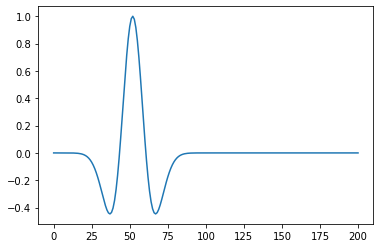

In [5]:
dt=0.002 #2ms
amostras=201
fp=13
wav=ricker(fp,dt,amostras)
plt.plot(wav)

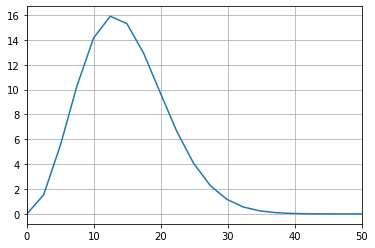

In [6]:
#para visualizar o espectro da wavelet de Ricker
freq=np.fft.rfftfreq(wav.size,dt)
plt.plot(freq,np.abs(np.fft.rfft(wav)));plt.xlim(0,50)
plt.grid()

## Equação de propagação

Juntando a definição do laplaciano, da derivada temporal e da fonte, é obtida uma equação para calcular o campo futuro usando a informação dos campos presente e passado. Substituindo na equação de onda é obtido que

\begin{equation}\frac{1}{v_{i,j}^2}\frac{P_{i,j}^{t+1}-2P_{i,j}^{t}+P_{i,j}^{t-1}}{\Delta t^2}=(\nabla^2 P)_{i,j}^t +s_{i_f,j_f}^t\end{equation}

Isolando para $P_{i,j}^{t+1}$

\begin{equation} P_{i,j}^{t+1}=2P_{i,j}^{t}-P_{i,j}^{t-1}+v_{i,j}^2\Delta t^2\left(  (\nabla^2 P)_{i,j}^t +s_{i_f,j_f}^t\right) \end{equation}

que é a equação básica de propagação.


## Criterios de estabilidade

### Condição de estabilidade numérica

Para o caso $2D$ e fazendo uso da análise de estabilidade de Von Neumann é obtida a condição *CFL*

\begin{equation} \frac{v_{max} \Delta t_{p}} {h_{efec}}\leq  \sqrt{\frac{4}{\sum_k |C_k|}}\end{equation}

onde 

\begin{equation}
\frac{1}{h_{efec}}=\sqrt{\frac{1}{\Delta x ^2}+ \frac{1}{\Delta z ^2}} 
\end{equation}

$C_k$ são os coeficientes de diferenças finitas que dependem da ordem do laplaciano usada. Por exemplo para a aproximação de segunda ordem $\sum_k |C_k|=1+2+1=4$ e para quarta ordem $\sum_k |C_k|=1/12+16/12+30/12+16/12+1/12=64/12=16/3$.

Essa condição fornece uma relação que devem satisfazer os parâmetros de propagação como as distâncias entre celas $\Delta x$ e $\Delta z$ e o passo de tempo de propagação $\Delta t_p$. Com essa condição pode ser calculado o passo de tempo de propagação correto para a propagação isolando $\Delta t_p$ a equação anterior como

\begin{equation}  \Delta t  \leq \frac{h_{efec}}{v_{max}}\sqrt{\frac{4}{\sum_k |C_k|}}=CFL\end{equation}

 Se os parâmetros não satisfazerem a condição *CFL*, a propagaçào vai ser instável numéricamente e para tempos grandes vão aparecer valores muito grandes.

### Condição de amostragem espacial

Mesmo sendo satisfazendo a condição CFL, a solução numérica da equação de onda pode gerar artifatos numéricos por causa de uma pobre amostragem espacial. Um criterio empírico é que o comprimento de onda mínimo gerado na propagação deve ser maior ou igual a D vezes o mínimo tamanho de cela, ou seja

\begin{equation} \lambda_{min}=v_{min}/(f_{max})\geq Dh \end{equation}

onde $h=\min(\Delta x, \Delta z)$. O fator $D$ depende da ordem do laplaciano. Para segunda ordem $D \approx 10$ e para a quarta ordem $D \approx 5$. Esta equação fornece um critério para saber qual é a frequência máxima que pode ser propagada no modelo de velocidade. Isolando a $f_{max}$ é obtido que

\begin{equation} f_{max} \leq \frac{v_{min}}{Dh}\end{equation}

No caso da wavelet de Ricker usando o fato que $f_{max}\approx 3f_{p}$, pode-se obter um criterio para obter a frequência pico da Ricker que pode ser propagada 

\begin{equation}f_{p} \leq \frac{v_{min}}{3Dh}\end{equation}

In [7]:
#estabilidade numérica
h=20;vmax=5000;dt=h/(np.sqrt(2)*vmax)
dt

0.0028284271247461896

In [8]:
#estabilidade espacial
h=20;vmin=1500;fmax=15;lmin=vmin/fmax
print(5*h)
print(lmin)
print(lmin>=5*h)

100
100.0
True


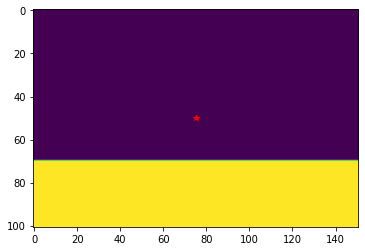

In [9]:
#definição de parâmetros de propagação
nz=101
nx=151
souz=nz//2
soux=nx//2
amostras=800
dx=15
dz=15
dt=0.003
vel=np.ones((nz,nx))*2000
vel[70::,:]=3000
fp=5
wavelet=ricker(fp,dt,amostras)
plt.imshow(vel)
plt.plot([soux],[souz],'*r')

In [10]:
hefec=1/np.sqrt(1/dx**2+1/dz**2)
cfl=np.sqrt(3/4)*hefec/vel.max()
print('O dt é ',dt,' e deve ser menor que CFL = ',cfl)
a=vel.min()/(3*fp)
b=5*dx
print('O comprimento de onda mínimo é ',a,' e 5h = ',b,'Portanto o criterio ','é satisfeito' if a>b else 'não é satisfeito' )

O dt é  0.003  e deve ser menor que CFL =  0.0030618621784789723
O comprimento de onda mínimo é  133.33333333333334  e 5h =  75 Portanto o criterio  é satisfeito


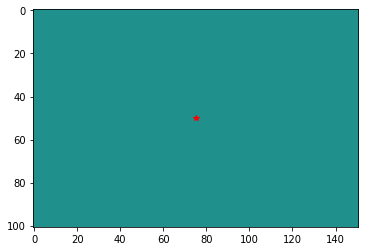

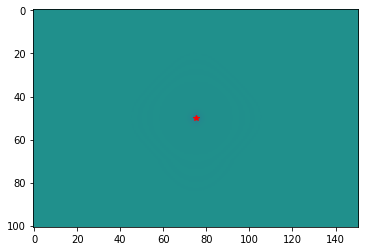

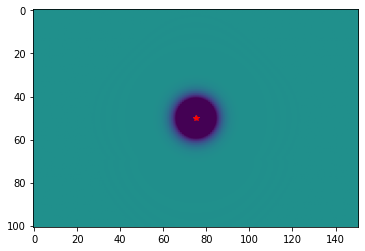

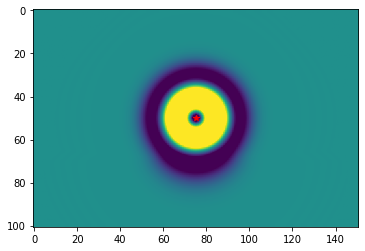

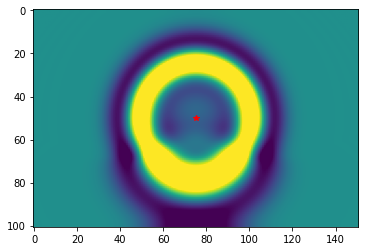

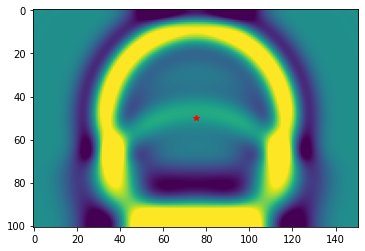

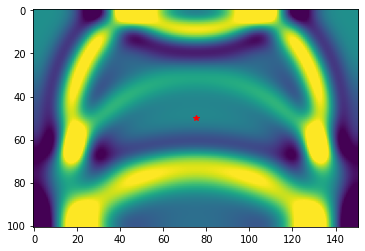

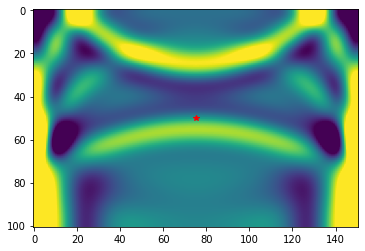

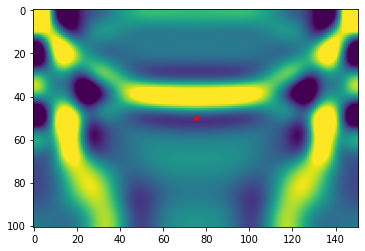

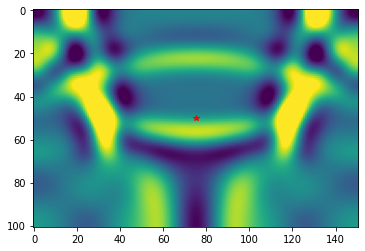

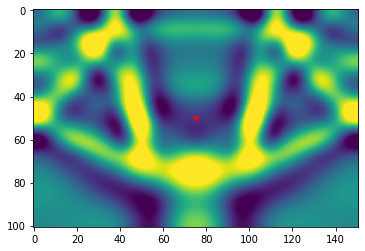

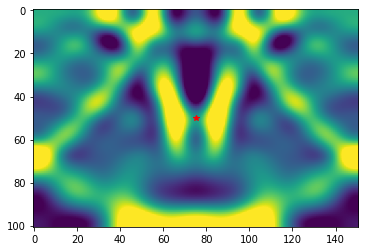

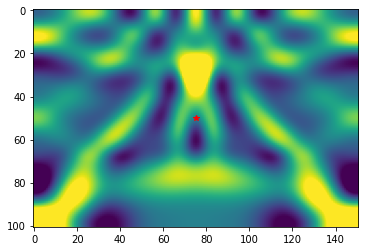

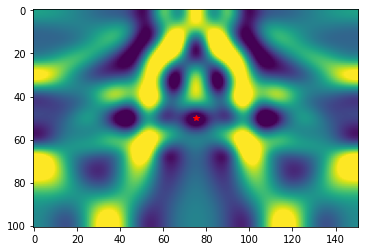

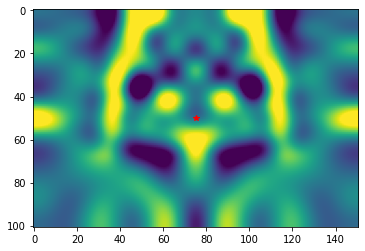

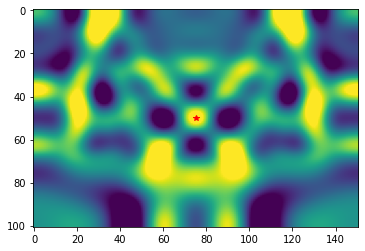

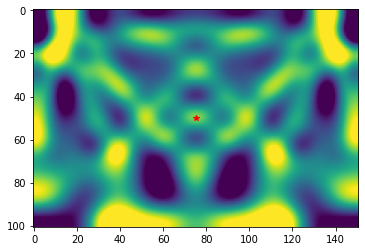

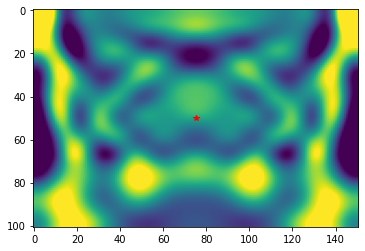

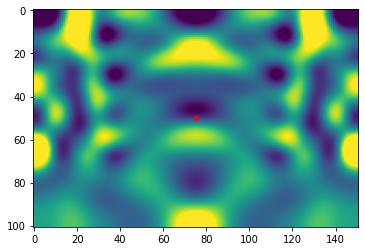

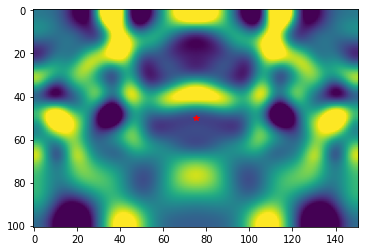

In [11]:
onda0=np.zeros((nz,nx))#onda no passado
onda1=np.zeros((nz,nx))#onda no presente
onda2=np.zeros((nz,nx))#onda no futuro
con=(vel*dt)**2
for t in range(amostras):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz,soux]=onda2[souz,soux]+con[souz,soux]*wavelet[t]
        if t%40==0:
            plt.figure();plt.imshow(onda2);plt.clim(-10,10)
            plt.plot([soux],[souz],'*r')
        onda0=onda1
        onda1=onda2

## Meio infinito

Como observado no resultado anterior, os limites da matriz computacional atuam como um refletor perfeito, mas isso não reflete o comportamento dos dados de campo, uma vez que o meio geológico é um "meio infinito". Para simular esse meio infinito existem varias técnicas, como as condiçoes de contorno absorventes (ABC - "Absorbing Boundary Conditions"), a borda PML ("Perfectly Matching Layer"). Por simplicidade, nesse tutorial é implementada a borda de esponja.

### Extensão do modelo
Para a implementação da borda de esponja primeiro dever ser estendido o modelo de velocidade, para isto a matriz que representa o modelo de velocidade é inserida numa matriz maior e as linhas e colunas na borda do modelo são copiadas na extensão. Ver a função a seguir:

In [12]:
def estendermodelo(vel,borda):
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    modelo=np.zeros((nza,nxa))
    modelo[borda:borda+nz,borda:borda+nx]=vel
    recheio=vel[:,0];
    for i in range(0,borda):
        modelo[borda:borda+nz,i]=recheio
    recheio=vel[:,nx-1]
    for i in range(borda+nx,nxa):
        modelo[borda:borda+nz,i]=recheio
    recheio=modelo[borda,:]
    for i in range(0,borda):
        modelo[i,:]=recheio
    recheio=modelo[borda+nz-1,:]
    for i in range(borda+nz,nza):
        modelo[i,:]=recheio
    return modelo

## criação da borda absorvente

Nas celas pertencentes à borda, a amplitude da onda é multiplicada por um fator de amortecimento. Esse fator deve estar entre 0.92 e 1, onde 1 é o fator que multiplica aos elementos no dominio físico correto. No paper do Cerjan (1985) é usada uma função da forma

\begin{equation} factor=\exp(-(0.015(nb-i)^2)) \end{equation}

Onde $nb$ é o número de elementos na borda que no artigo do Cerjan aconselha usar de 20 a 30 celas. Nesse tutorial vai ser usado um fator parecido calculado pela equação

\begin{equation} factor=\frac{1+\cos(\pi(nb-i))}{2(taper*(nb))} \end{equation}

Que possui um comportamento parecido à borda do Cerjan e pode ser ajustada para qualquer tamanho da borda. O valor do $taper$ pode ser entre 5.3 e 7

In [13]:
def taper(nz,nx,borda):
    damp=6.5*borda
    nxa=nx+2*borda
    nza=nz+2*borda
    amortece=np.ones((nza,nxa))
    for i in range(0,borda):
        amortece[i,:]=amortece[-1-i,:]=0.5*(1+np.cos(np.pi*(borda-i)/damp))
    for i in range(0,borda):
        amortece[:,i]=amortece[:,i]*0.5*(1+np.cos(np.pi*(borda-i)/damp))
        amortece[:,-1-i]=amortece[:,-1-i]*0.5*(1+np.cos(np.pi*(borda-i)/damp))
    return amortece

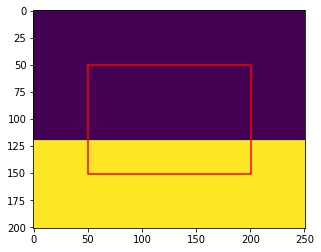

In [14]:
borda=50
ret_x=[borda,borda+nx,borda+nx,borda,borda]
ret_z=[borda,borda,borda+nz,borda+nz,borda]
plt.imshow(estendermodelo(vel,borda))
plt.plot(ret_x,ret_z,'r')

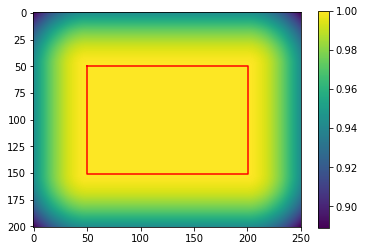

In [15]:
amortece=taper(nz,nx,borda)
plt.imshow(amortece);plt.colorbar()
plt.plot(ret_x,ret_z,'r')

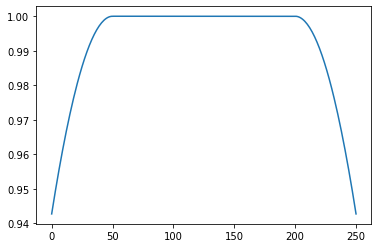

In [16]:
plt.plot(amortece[nz//2,:])

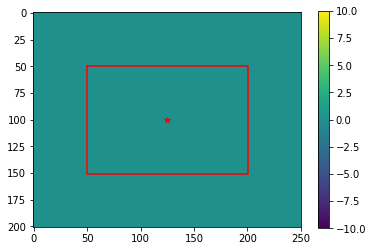

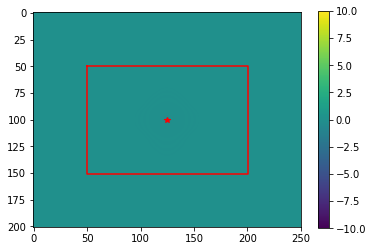

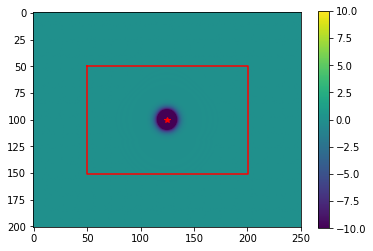

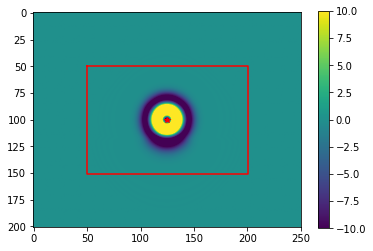

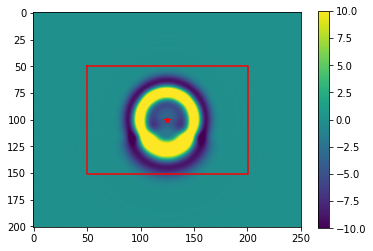

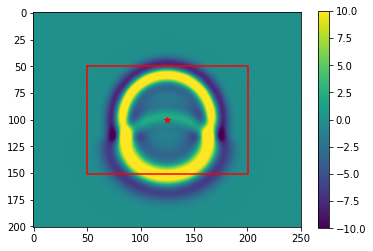

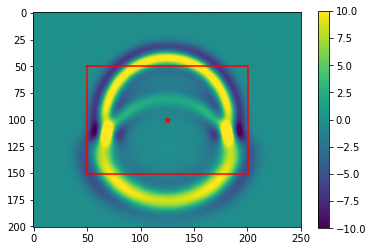

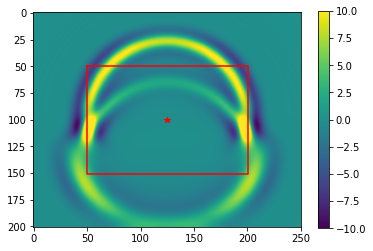

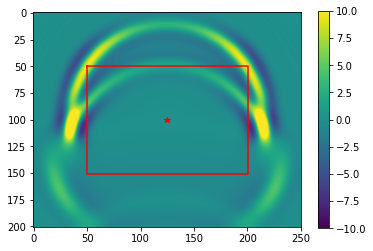

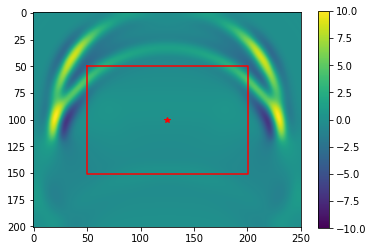

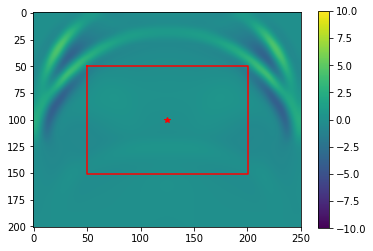

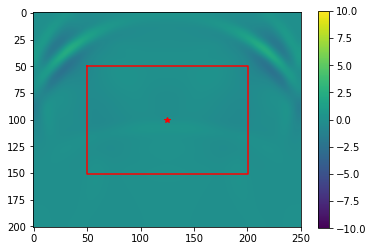

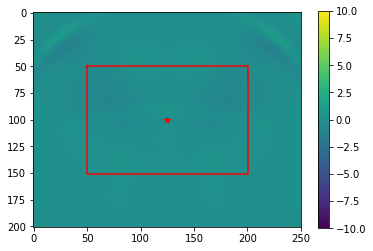

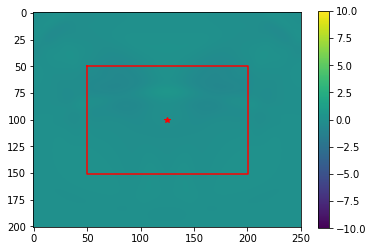

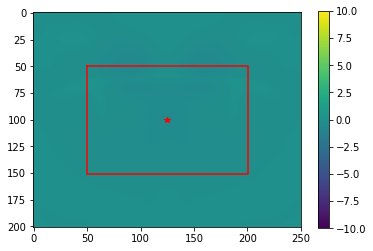

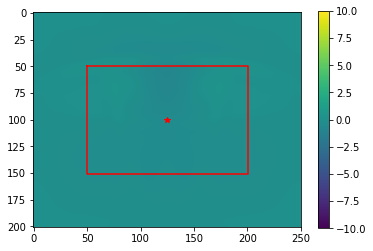

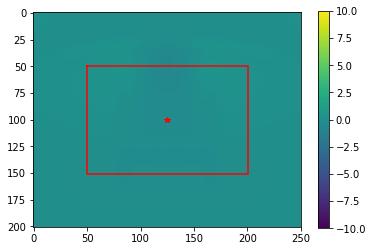

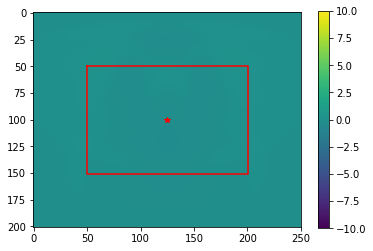

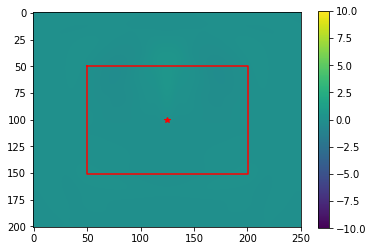

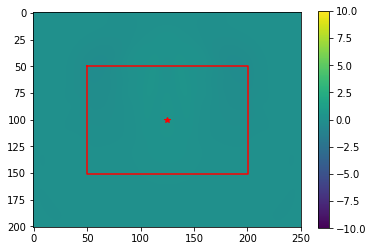

In [17]:
amortecedor=taper(nz,nx,borda)
onda0=np.zeros(amortecedor.shape)
onda1=np.zeros(amortecedor.shape)
onda2=np.zeros(amortecedor.shape)
vel1=estendermodelo(vel,borda)
con=(vel1*dt)**2
for t in range(amostras):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet[t]
        if t%40==0:
            plt.figure();plt.imshow(onda2);plt.colorbar();plt.clim(-10,10)
            plt.plot(ret_x,ret_z,'r')
            plt.plot([soux+borda],[souz+borda],'*r')
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor

## Simulação de um sismograma de campo

Para simular o sismograma de campo é necessário ir coletando as amplitudes do campo correspondentes com a posição dos receptores para cada instante de tempo e ir armazenando numa matriz cujas colunas correspondem a cada receptor e as linhas correspondem com cada amostra temporal. ver o código na seguinte cela que é uma alteração do código anterior

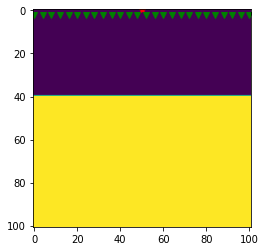

In [18]:
nz=101
nx=101
dx=15
dz=15
dt=0.002
amostras=800
borda=50
souz=0
soux=nx//2
recx=np.arange(0,nx,4)
recz=np.ones(recx.size,dtype='int')*2
fp=10
vel=np.ones((nz,nx))*2000
vel[40::,:]=3000

plt.imshow(vel)
plt.plot([soux],[souz],'*r')
plt.plot(recx,recz,'vg')

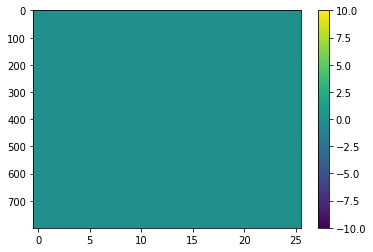

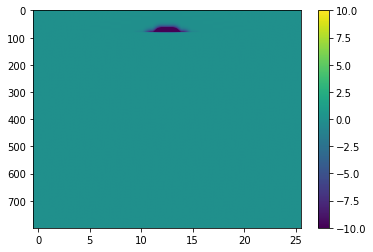

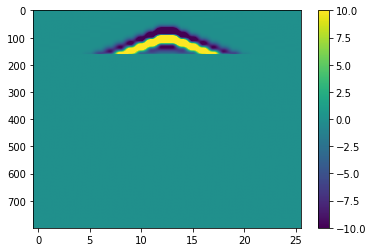

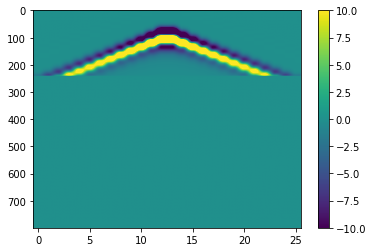

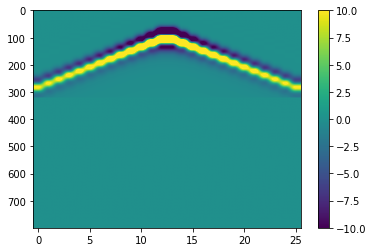

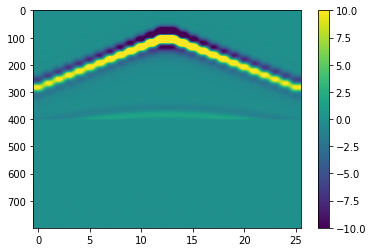

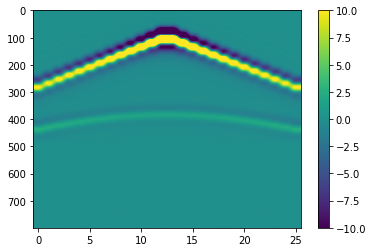

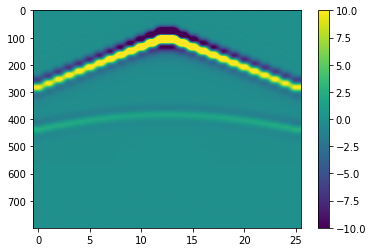

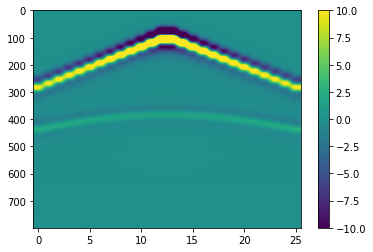

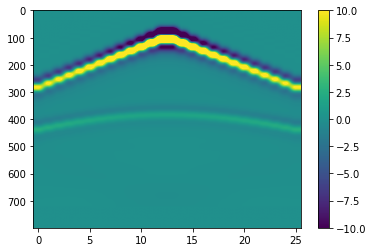

In [19]:
amortecedor=taper(nz,nx,borda)
onda0=np.zeros(amortecedor.shape)
onda1=np.zeros(amortecedor.shape)
onda2=np.zeros(amortecedor.shape)
vel1=estendermodelo(vel,borda)
nrecs=recx.size
tiro=np.zeros((amostras,nrecs))

con=(vel1*dt)**2
for t in range(amostras):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet[t]
        for j in range(nrecs):
            tiro[t,j]=onda2[recz[j]+borda,recx[j]+borda]
        if t%80==0:
            plt.figure();plt.imshow(tiro,aspect='auto');plt.colorbar();plt.clim(-10,10)
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor

(800, 26)

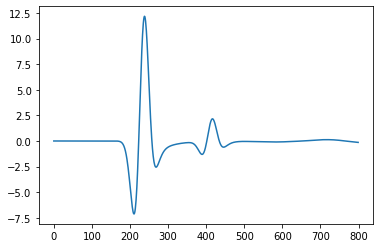

In [20]:
plt.plot(tiro[:,3])
tiro.shape

## Usando modelo mais complexos

Toda a implementação anterior pode ser definida numa única função de python que faça a propagação e devolva o tiro. A seguir, vamos criar a função de python e vamos testar ela com um modelo de duas camadas e com o modelo SEG/EAGE overthurst. 

In [21]:
def propagador(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda):
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    vel1=estendermodelo(vel,borda)
    amortecedor=taper(nz,nx,borda)
    onda0=np.zeros((nza,nxa))
    onda1=np.zeros((nza,nxa))
    onda2=np.zeros((nza,nxa))
    nrecs=recx.size
    tiro=np.zeros((amostras,nrecs))
    con=(vel1*dt)**2
    for t in range(amostras):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet[t]
        for j in range(nrecs):
            tiro[t,j]=onda2[recz[j]+borda,recx[j]+borda]
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
    return tiro

In [22]:
nz=101
nx=101
dx=15
dz=15
dt=0.002
amostras=800
borda=50
souz=0
soux=nx//2
recx=np.arange(0,nx,4)
recz=np.ones(recx.size,dtype='int')*2
fp=10
#Definição de modelo de duas camadas
vel=np.ones((nz,nx))*2500.0
vel[nz//2::,:]=3500.0
wavelet=ricker(fp,dt,amostras)

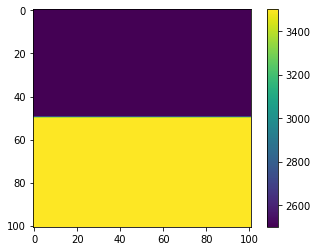

In [23]:
plt.imshow(vel);plt.colorbar()

In [24]:
tic=time.time()
tiro=propagador(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda)
toc=time.time()
print('demorei ',toc-tic,' segundos')

demorei  0.7793214321136475  segundos


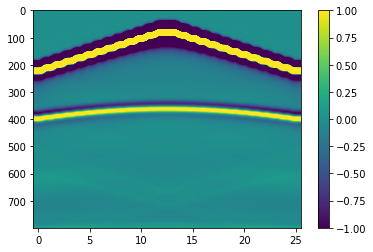

In [25]:
plt.imshow(tiro,aspect='auto');plt.colorbar();plt.clim(-1.0,1.0)

In [26]:
#agora com o modelo overthurst
nz=187
nx=801
dx=25
dz=25
dt=0.002
amostras=3000
borda=50
souz=0
soux=nx//2
recx=np.arange(0,nx,4)
recz=np.ones(recx.size,dtype='int')*2
fp=8
wavelet=ricker(fp,dt,amostras)

In [27]:
vel=np.fromfile('overthrust.bin',dtype='float32')
vel.shape

(149787,)

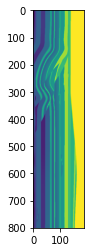

In [28]:
vel=vel.reshape((nx,nz))
plt.imshow(vel)

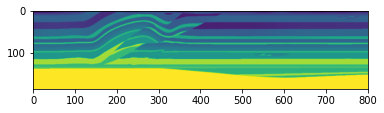

In [29]:
vel=vel.T
plt.imshow(vel)

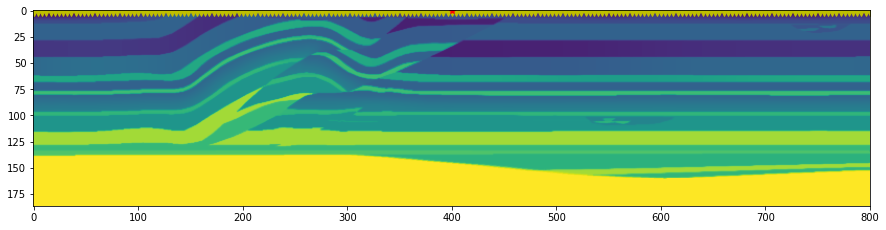

In [30]:
#esta é a forma para ler os arquivos binários que o grupo usa como padrão
vel=np.fromfile('overthrust.bin',dtype='float32')
vel=vel.reshape((nx,nz)).T
#aqui vamos visualizar o modelos de velocidade
plt.figure(figsize=(15,5))
plt.imshow(vel)
#aqui fazemos o plot de receptores e fontes sobreposto ao modelo
plt.plot(recx,recz,'vy')
plt.plot([soux],[souz],'*r')

In [31]:
tic=time.time()
tiro1=propagador(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda)
toc=time.time()
print('demorei ',toc-tic,' segundos')

demorei  38.81525254249573  segundos


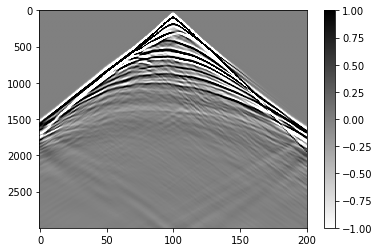

In [32]:
plt.imshow(tiro1,aspect='auto',cmap='binary');plt.colorbar();plt.clim(-1,1)